# LSR Method

New method to find $\pi$ taking into account noise. \
L=$\sum_t \frac{1}{2} (\ln(\pi\cdot\sqrt{\epsilon \; f(t)})+\frac{(\pi \cdot\Delta f)^2}{(\pi \cdot \sqrt{\epsilon f(t)})^2}) $ \
$\frac{\partial L}{\partial \pi_i} = \sum_t \frac{1}{2} [\frac{\sqrt{\epsilon_i f_i(t)}}{\pi \cdot \sqrt{\epsilon\; f(t)}}+\frac{(\pi \cdot \sqrt{\epsilon\; f(t)})(\pi \cdot \Delta f(t)) \Delta f_i(t)-(\pi \cdot \Delta f(t))^2 \sqrt{\epsilon_i \; f_i(t)}}{(\pi \cdot \sqrt{\epsilon f(t)})^3}] $

# Setting Everything Up:

In [25]:
import numpy as np
import seaborn as sns
from scipy.linalg import eig
import matplotlib.pyplot as plt 
plt.rcParams['text.usetex'] = False

from modules.LDS import Kalman_EM
from modules.WF_sim import *
from scipy.optimize import minimize
from scipy.optimize import nnls
from pathlib import Path

Total counts shape:  (3, 10)
A is not provide! A_demo is used.
(3, 20, 10)


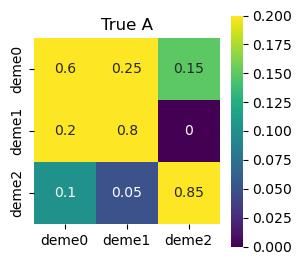

True Neff =  [1000, 1000, 1000]
True measurement noise overdispersion =  [1.0, 1.0, 1.0]
Eigenvalues of A: 
 [1.        +0.j 0.81374586+0.j 0.43625414+0.j]
Eigenvectors of A: 
 [[-0.48507125 -0.18910989  0.80640186]
 [-0.72760688 -0.59332447 -0.51404781]
 [-0.48507125  0.78243436 -0.29235405]]
Check eigvec-eigval relationship: 
 1.0

Lowest left eigenvector of A (normalized):  [0.48507125 0.72760688 0.48507125]
Lowest right eigenvalue of A:     1


In [26]:
ND = 3 # the number of demes 
T=10 # the number of timepoints
Csn =[1.0]*ND # strength of measurement noise overdispersion
Npop = [1000]*ND # effective population size
if ND == 3:
    totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
elif ND > 3:
    totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint
print("Total counts shape: ", totcounts.shape)

Ntraj = 20 # number of trajectories to simulate
A,counts,B=WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
print(counts.shape)
demes=['deme'+str(i) for i in range(ND)]

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

print("True Neff = ", Npop)
print("True measurement noise overdispersion = ", Csn )

# find the lowest left eigenvector of A
eigvals, eigvecs = eig(A, left=True, right=False)
# normalize the eigenvectors
eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
ordering = np.flip(np.argsort(eigvals.real))
eigvals = eigvals[ordering]
eigvecs = eigvecs[:,ordering]
print("Eigenvalues of A: \n", eigvals)
print("Eigenvectors of A: \n", eigvecs)
# check eigvector-eigenvalue relationship
print("Check eigvec-eigval relationship: \n", eigvec_true.T @ A @ eigvec_true)

print("\nLowest left eigenvector of A (normalized): ", eigvec_true)
print(f"Lowest right eigenvalue of A: {eigvals[np.argmax(eigvals.real)].real:5g}")

# Setting Up Frequencies:

In [27]:
freqs = counts / (totcounts[:,None,:]) #calculating frequencies over all trajectories
def freq_setup(freqs):
    ND, Ntraj, T = freqs.shape
    f_current=[] #initialise our f(t)
    f_next=[] #initialise our f(t+1)
    for i in range(Ntraj): #make sure we cover all f_i(t) and f_i(t+1)
        for t in range(T-1): #make sure we cover all t
            f_current.append(freqs[:,i,t]) #append with current time
            f_next.append(freqs[:,i,t+1]) #append with next time
    f_current=np.stack(f_current) #convert 1D list into 2D vector comprising of f(t) of all alleles
    f_next=np.stack(f_next) #do the same for f(t+1)
    df=f_next-f_current
    af=f_next+f_current
    '''print (f_next.shape)'''
    '''print (freqs)'''
    return f_current, f_next, df, af
print (freqs.shape)
f_t, f_t2, df, af = freq_setup(freqs)
print(f_t.shape)

(3, 20, 10)
(180, 3)


# Simplified Dynamics to Find $\pi$
Assuming true frequencies are observed (i.e. $c_i=0$)

In [28]:
#initial pi finder to get a value for simplified dynamics
def set_up_lsr(freqs, lamb):
    _, _, df, _=freq_setup(freqs)
    ND, _, _ = freqs.shape
    A=df.T @ df / ND
    y=lamb*np.ones(ND)
    return A, y

def lsr_numpy(freqs, lamb):
    A, y=set_up_lsr(freqs, lamb)
    pi, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
    pi /= np.sum(pi)
    return pi

def error_checker_numpy(freqs, lamb):
        pi=lsr_numpy(freqs, lamb)
        f_t, f_t2, _, _ = freq_setup(freqs)
        #print (pi.shape)
        #print (f_t.shape)
        err=(f_t2-f_t)@pi
        err2=np.mean(err**2)
        err_rms=np.sqrt(err2)
        return err, err2, err_rms
pi_star_dot=lsr_numpy(freqs, lamb=3.0)
err, err2, err_rms=error_checker_numpy(freqs, lamb=3.0)

print('pi* (linear regression)=', pi_star_dot)
print(f'sum of pi* is:{np.sum(pi_star_dot)}')
print('MSE (linear regression)=', err2)
print('RMSE (linear regression)=', err_rms)
print(pi_star_dot.shape)
f_t, f_t2, df, af = freq_setup(freqs)
print (np.mean(df@pi_star_dot)**2)

pi* (linear regression)= [0.34323017 0.42156978 0.23520005]
sum of pi* is:1.0
MSE (linear regression)= 2.1788189583245853e-05
RMSE (linear regression)= 0.004667782083950134
(3,)
8.322951796007393e-08


# Solving Using LSR and Scipy Minimise
Here, want to try and find values for $\epsilon$ and $\pi$

In [29]:
#setting up matrix and vector components

def l_setup(freqs,pi): #set up our l vector
    ND, Ntraj, T =freqs.shape
    l=np.zeros(T-1)
    for t in range(T-1):
        df=(freqs[:,:,t+1]-freqs[:,:,t])/totcounts[:,None,t]
        dot=np.dot(pi, df)
        l[t]=np.sum(dot**2)
    #print (l)
    return l

def pi_matrix(freqs,pi):
    ND, Ntraj, T = freqs.shape
    pi2=pi**2 
    PI=np.zeros((T-1,ND))
    for t in range(T-1):
        af=(freqs[:,:,t+1]+freqs[:,:,t]) / totcounts[:,None,t]
        tot_af=np.sum(af, axis=1) # /totcounts[:,t]
        PI[t]=pi2 * tot_af
    print(PI)
    print(tot_af)
    print(pi2)
    return PI
def eps_0(freqs,pi):
    l=l_setup(freqs,pi)
    PI=pi_matrix(freqs,pi)
    ep_1=np.linalg.pinv(PI) @ l
    ep_2=nnls(PI, l)
    return ep_1 #, ep_2
eps_lsr =eps_0(freqs, pi_star_dot) #eps_nnls
print(eps_lsr)
#print(eps_nnls)

[[1.14508357e-04 1.19665524e-04 7.63403091e-05]
 [1.17777499e-04 1.14847308e-04 7.49634791e-05]
 [1.20339801e-04 1.08370362e-04 7.09313339e-05]
 [1.16275461e-04 1.08212388e-04 7.19639565e-05]
 [1.15156295e-04 1.11292887e-04 7.48159616e-05]
 [1.14096032e-04 1.12220986e-04 7.75204492e-05]
 [1.13860418e-04 1.09871118e-04 7.71762417e-05]
 [1.12122766e-04 1.08054414e-04 7.26769577e-05]
 [1.15450812e-04 1.07244796e-04 7.03166777e-05]]
[0.00098    0.00060344 0.00127111]
[0.11780695 0.17772108 0.05531906]
[-6.90140852e-07  4.02996661e-06 -3.51519330e-06]


In [30]:
#recompute pi with current epsilon
def new_loss(pi, eps, freqs):
    f_t, f_t2, df, af =freq_setup(freqs)
    #sqrt=np.sqrt(eps*f_t)
    sqrt = np.sqrt(np.maximum(eps * f_t, 1e-10)) #want to ensure sqrt is non zero so give it a lower bound limit of 1*10^-10
    dot_var=sqrt@pi 
    #Ln=np.log(dot_var)
    Ln =1/2*np.log(np.maximum(dot_var, 1e-10)) #again want to ensure the log is >0, so introduce lower limit of 1^-10
    dot_df=df@pi
    other=1/2*(dot_df)**2/(dot_var)**2
    L=np.sum(Ln+other)
    return L
def new_grad_loss(pi, eps, freqs):
    f_t, f_t2, df, af =freq_setup(freqs)
    sqrt=np.sqrt(eps *f_t)
    dot_var=sqrt@pi
    dot_df =df @ pi 
    grad_Ln=1/2*sqrt/(pi @ sqrt)
    grad_other=((dot_var)*(dot_df)*df-(dot_df)**2*sqrt)/(dot_var)**3
    grad_L_i=grad_Ln+grad_other
    grad_L=np.sum(grad_L_i, axis=0)
    return grad_L

def new_pi_finder(freqs, eps):
    ND, Ntraj, T =freqs.shape
    
    pi0=pi_star_dot #define guess
    cons = (
        {'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1},
        {'type': 'ineq', 'fun': lambda pi: pi},
    )
    result = minimize(
        fun=new_loss,
        x0=pi0,
        args=(eps, freqs),
        method='SLSQP',
        constraints=cons,
        options={'disp':True}
    )
    #again use scipy minimize
    pi=result.x #return result
    return pi
eps=eps_0(freqs, pi_star_dot)
pi_star=new_pi_finder(freqs, eps)
print(pi_star)


[[1.14508357e-04 1.19665524e-04 7.63403091e-05]
 [1.17777499e-04 1.14847308e-04 7.49634791e-05]
 [1.20339801e-04 1.08370362e-04 7.09313339e-05]
 [1.16275461e-04 1.08212388e-04 7.19639565e-05]
 [1.15156295e-04 1.11292887e-04 7.48159616e-05]
 [1.14096032e-04 1.12220986e-04 7.75204492e-05]
 [1.13860418e-04 1.09871118e-04 7.71762417e-05]
 [1.12122766e-04 1.08054414e-04 7.26769577e-05]
 [1.15450812e-04 1.07244796e-04 7.03166777e-05]]
[0.00098    0.00060344 0.00127111]
[0.11780695 0.17772108 0.05531906]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 83022.33264358612
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[0.34323017 0.42156978 0.23520005]


In [38]:
#now want to iteratively repeat the process to narrow it down
def iterater(freqs, max_iter=15, tol=1e-10, lamb=1.0, verbose=False):
    ND=freqs.shape[0]
    pi=lsr_numpy(freqs, lamb) #compute original pi from lsr model (simplified dynamics)
    #print(pi)
    pi_hist=[pi.copy()] #update histogram to represent pi values
    eps_hist=[] #update histogram for epsilon values also
    for i in range(max_iter): #iterate over a certain number of steps
        eps=eps_0(freqs,pi) #compute epsilon
        eps_hist.append(eps.copy()) #append histogram
        pi_new=new_pi_finder(freqs, eps) #now use this epsilon for pi values
        pi_hist.append(pi_new.copy())
        '''if verbose: #check for convergence of pi's
            print(f"Iter {i+1}: pi = {pi_new}, eps = {eps}")
        if np.linalg.norm(pi_new - pi) < tol:
            if verbose:
                print(f"Converged at iteration {i+1}")
            break'''
        pi=pi_new #compute new pi
    pi_deltas = [np.linalg.norm(pi_hist[i+1] - pi_hist[i]) for i in range(len(pi_hist)-1)] #compile a list of difference bdetween pis
    return pi, eps, pi_hist, eps_hist , pi_deltas

pi_final, eps_final, pi_hist, eps_hist, pi_deltas = iterater(freqs, max_iter=20, tol=1e-6, lamb=1.0, verbose=True)
print("Final pi:", pi_final)
print("Final epsilon:", eps_final)

[[1.14508357e-04 1.19665524e-04 7.63403091e-05]
 [1.17777499e-04 1.14847308e-04 7.49634791e-05]
 [1.20339801e-04 1.08370362e-04 7.09313339e-05]
 [1.16275461e-04 1.08212388e-04 7.19639565e-05]
 [1.15156295e-04 1.11292887e-04 7.48159616e-05]
 [1.14096032e-04 1.12220986e-04 7.75204492e-05]
 [1.13860418e-04 1.09871118e-04 7.71762417e-05]
 [1.12122766e-04 1.08054414e-04 7.26769577e-05]
 [1.15450812e-04 1.07244796e-04 7.03166777e-05]]
[0.00098    0.00060344 0.00127111]
[0.11780695 0.17772108 0.05531906]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 83022.33264358566
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[[1.14508357e-04 1.19665524e-04 7.63403091e-05]
 [1.17777499e-04 1.14847308e-04 7.49634791e-05]
 [1.20339801e-04 1.08370362e-04 7.09313339e-05]
 [1.16275461e-04 1.08212388e-04 7.19639565e-05]
 [1.15156295e-04 1.11292887e-04 7.48159616e-05]
 [1.14096032e-04 1.12220986e-04 7.75204492e-05]
 [1

In [32]:
#check how accurate our value of pi is
def error_checker(freqs, pi):
        f_t, f_t2, _, _ = freq_setup(freqs)
        #print (pi.shape)
        #print (f_t.shape)
        err=(f_t2-f_t)@pi
        err2=np.mean(err**2)
        err_rms=np.sqrt(err2)
        return err, err2, err_rms
err, MSE, RMSE = error_checker(freqs, pi_final)
print(f'MSE={MSE}')
print(f'RMSE={RMSE}')


MSE=2.1788189583245853e-05
RMSE=0.004667782083950134


# Presenting the Data
Here, we aim to show how both $\pi$ and $\epsilon$ tend to converge over different iterations 

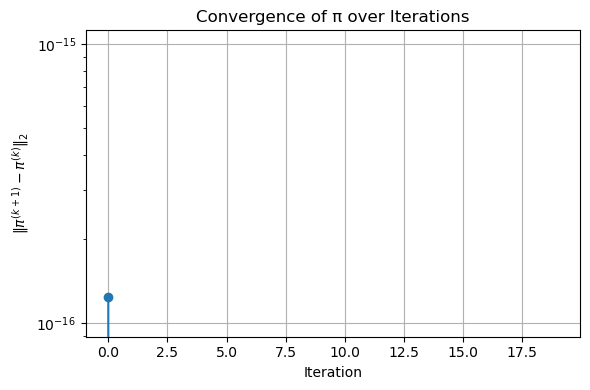

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(pi_deltas, marker='o')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$\|\pi^{(k+1)} - \pi^{(k)}\|_2$')
plt.title('Convergence of π over Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\matty\AppData\Local\Temp\ipykernel_10408\818759332.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(pi_array[:, i], label=f"$\pi_{i}$")


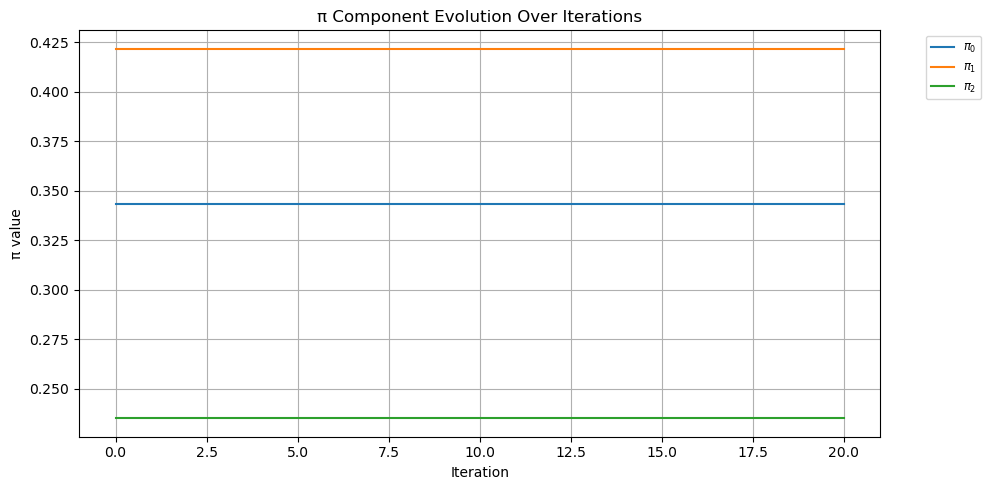

In [40]:
pi_array = np.array(pi_hist)  # shape: (iterations, ND)

plt.figure(figsize=(10, 5))
for i in range(pi_array.shape[1]):
    plt.plot(pi_array[:, i], label=f"$\pi_{i}$")

plt.xlabel("Iteration")
plt.ylabel("π value")
plt.title("π Component Evolution Over Iterations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\matty\AppData\Local\Temp\ipykernel_10408\1976791751.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(eps_array[:, i], label=f"$\epsilon_{i}$")


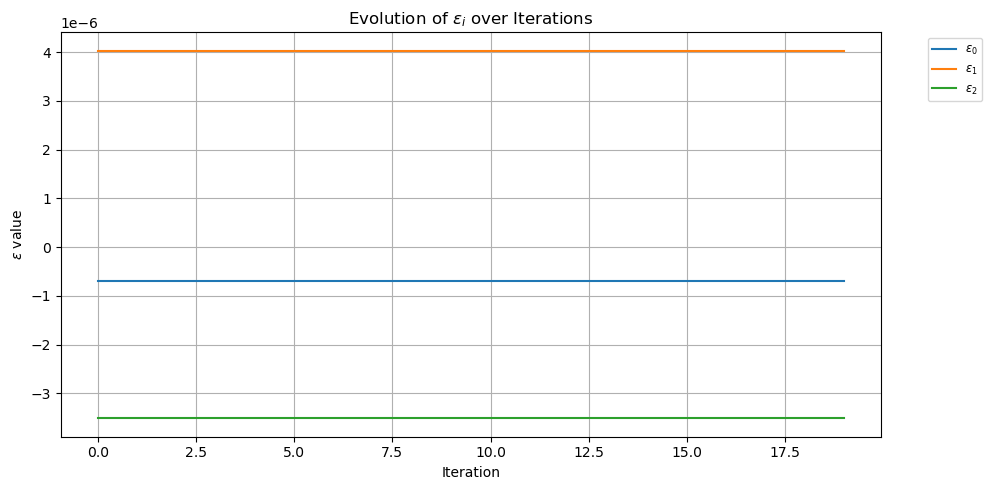

In [41]:
eps_array = np.array(eps_hist)  # shape: (iterations, ND)

plt.figure(figsize=(10, 5))
for i in range(eps_array.shape[1]):
    plt.plot(eps_array[:, i], label=f"$\epsilon_{i}$")

plt.xlabel("Iteration")
plt.ylabel(r"$\epsilon$ value")
plt.title(r"Evolution of $\epsilon_i$ over Iterations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\matty\AppData\Local\Temp\ipykernel_10408\3848135845.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('Value of $\pi_i$')
C:\Users\matty\AppData\Local\Temp\ipykernel_10408\3848135845.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Histogram of Final $\pi$ Values')


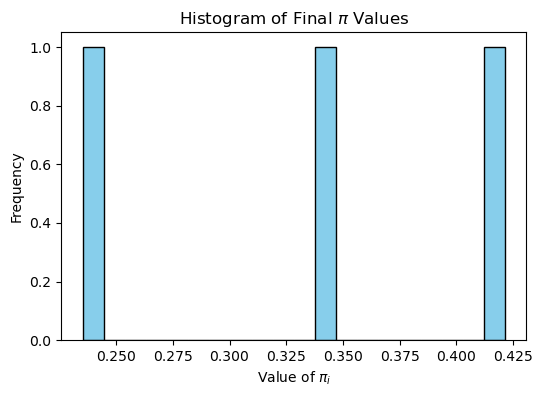

In [36]:
import matplotlib.pyplot as plt

# Plot histogram of final pi values
plt.figure(figsize=(6,4))
plt.hist(pi_final, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Value of $\pi_i$')
plt.ylabel('Frequency')
plt.title('Histogram of Final $\pi$ Values')
plt.show()

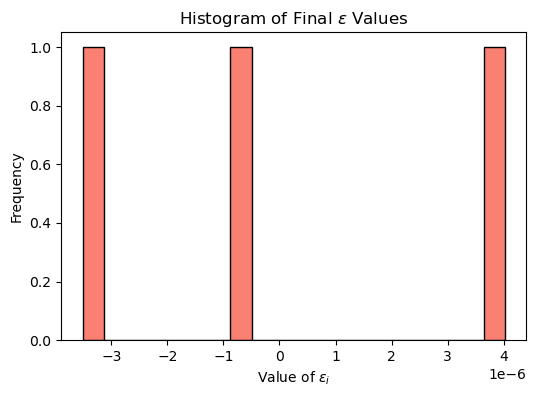

In [37]:
# Plot histogram of final epsilon values
plt.figure(figsize=(6,4))
plt.hist(eps_final, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Value of $\\epsilon_i$')
plt.ylabel('Frequency')
plt.title('Histogram of Final $\\epsilon$ Values')
plt.show()